<a href="https://colab.research.google.com/github/Mandloi1/projectwork/blob/master/featuremodel_71.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import PIL
import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from skimage.filters import gabor
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops

In [3]:
trainDset = datasets.ImageFolder('/content/drive/My Drive/NEU/train')
testDset = datasets.ImageFolder('/content/drive/My Drive/NEU/test')


In [4]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainDset)))
print('No. of samples in test set: '+str(len(testDset)))

No. of samples in train set: 1440
No. of samples in test set: 180


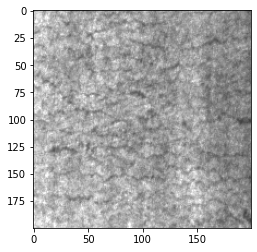

In [5]:
# Feature extraction on single image
img = trainDset[0][0] #PIL image
img_gray = img.convert('L') #Converting to grayscale
img_arr = np.array(img_gray) #Converting to array
plt.imshow(img)

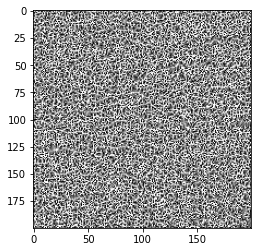

In [6]:

# Finding LBP
feat_lbp = local_binary_pattern(img_arr,8,1,'uniform') #Radius = 1, No. of neighbours = 8
feat_lbp = np.uint8((feat_lbp/feat_lbp.max())*255) #Converting to unit8
lbp_img = PIL.Image.fromarray(feat_lbp) #Conversion from array to PIL image
plt.imshow(lbp_img,cmap='gray') #Displaying LBP

In [7]:
# Energy and Entropy of LBP feature
lbp_hist,_ = np.histogram(feat_lbp,8)
lbp_hist = np.array(lbp_hist,dtype=float)
lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
lbp_energy = np.sum(lbp_prob**2)
lbp_entropy = -np.sum(np.multiply(lbp_prob,np.log2(lbp_prob)))
print('LBP energy = '+str(lbp_energy))
print('LBP entropy = '+str(lbp_entropy))

LBP energy = 0.15557908625
LBP entropy = 2.850178734505866


In [8]:
# Finding GLCM features from co-occurance matrix
gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True) # Co-occurance matrix
contrast = greycoprops(gCoMat, prop='contrast')
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
homogeneity = greycoprops(gCoMat, prop='homogeneity')
energy = greycoprops(gCoMat, prop='energy')
correlation = greycoprops(gCoMat, prop='correlation')
print('Contrast = '+str(contrast[0][0]))
print('Dissimilarity = '+str(dissimilarity[0][0]))
print('Homogeneity = '+str(homogeneity[0][0]))
print('Energy = '+str(energy[0][0]))
print('Correlation = '+str(correlation[0][0]))

Contrast = 548.713131313131
Dissimilarity = 18.4550505050505
Homogeneity = 0.05453788335824611
Energy = 0.012278584357037095
Correlation = 0.650861379266939


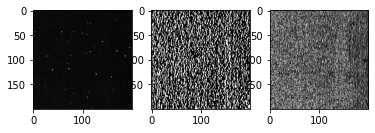

In [9]:

# Gabor filter
gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
# Displaying the filter response
fig, ax = plt.subplots(1,3)    
ax[0].imshow(gaborFilt_real,cmap='gray')
ax[1].imshow(gaborFilt_imag,cmap='gray')
ax[2].imshow(gaborFilt,cmap='gray')

In [10]:

# Energy and Entropy of Gabor filter response
gabor_hist,_ = np.histogram(gaborFilt,8)
gabor_hist = np.array(gabor_hist,dtype=float)
gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
gabor_energy = np.sum(gabor_prob**2)
gabor_entropy = -np.sum(np.multiply(gabor_prob,np.log2(gabor_prob)))
print('Gabor energy = '+str(gabor_energy))
print('Gabor entropy = '+str(gabor_entropy))

Gabor energy = 0.15475283750000002
Gabor entropy = 2.8157298367007098


In [11]:
# Generating training data by extracting features from all images
label = []
featLength = 2+5+2
trainFeats = np.zeros((len(trainDset),featLength)) #Feature vector of each image is of size 1x1030
for tr in tqdm.tqdm_notebook(range(len(trainDset))):

    img = trainDset[tr][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob))) 
      # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)
    trainFeats[tr,:] = concat_feat #Stacking features vectors for each image
    # Class label
    label.append(trainDset[tr][1])
trainLabel = np.array(label) #Conversion from list to array  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


In [12]:
# Generating testing data by extracting features from all images
label = []
testFeats = np.zeros((len(testDset),featLength)) #Feature vector of each image is of size 1x1030
for ts in tqdm.tqdm_notebook(range(len(testDset))):
    
    img = testDset[ts][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
      # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)    
    testFeats[ts,:] = concat_feat  #Stacking features vectors for each image
    # Class label
    label.append(testDset[ts][1])
testLabel = np.array(label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


In [13]:
# Normalizing the train features to the range [0,1]
trMaxs = np.amax(trainFeats,axis=0) #Finding maximum along each column
trMins = np.amin(trainFeats,axis=0) #Finding maximum along each column
trMaxs_rep = np.tile(trMaxs,(1440,1)) #Repeating the maximum value along the rows
trMins_rep = np.tile(trMins,(1440,1)) #Repeating the minimum value along the rows
trainFeatsNorm = np.divide(trainFeats-trMins_rep,trMaxs_rep) #Element-wise division
# Normalizing the test features
tsMaxs_rep = np.tile(trMaxs,(180,1)) #Repeating the maximum value along the rows
tsMins_rep = np.tile(trMins,(180,1)) #Repeating the maximum value along the rows
testFeatsNorm = np.divide(testFeats-tsMins_rep,tsMaxs_rep) #Element-wise division

In [14]:

# Saving normalized training data and labels
with open("trainFeats.pckl", "wb") as f:
    pickle.dump(trainFeatsNorm, f)
with open("trainLabel.pckl", "wb") as f:
    pickle.dump(trainLabel, f)
    
# Saving normalized testing data and labels
with open("testFeats.pckl", "wb") as f:
    pickle.dump(testFeatsNorm, f)
with open("testLabel.pckl", "wb") as f:
    pickle.dump(testLabel, f)
    
print('Files saved to disk!')

Files saved to disk!


In [26]:
import pandas as pd

object = pd.read_pickle(r'/content/trainLabel.pckl')

In [28]:
object

array([0, 0, 0, ..., 5, 5, 5])

In [17]:

%matplotlib inline
import os
import time
import tqdm
import torch
import pickle
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader

print(torch.__version__) # This code has been updated for PyTorch 1.0.0


1.6.0+cu101


In [18]:
# Loading the saved features
with open("trainFeats.pckl", "rb") as f:
    trainFeats = pickle.load(f)
with open("trainLabel.pckl", "rb") as f:
    trainLabel = pickle.load(f)
    
with open("testFeats.pckl", "rb") as f:
    testFeats = pickle.load(f)
with open("testLabel.pckl", "rb") as f:
    testLabel = pickle.load(f)
    
print('Finished loading saved feature matrices from the disk!')

Finished loading saved feature matrices from the disk!


In [19]:
# Defining the perceptron
class perceptron(nn.Module):
    def __init__(self,n_channels): #n_channels => length of feature vector
        super(perceptron, self).__init__()
        self.L = nn.Linear(n_channels,6) #Mapping from input to output
    def forward(self,x): #x => Input
        x = self.L(x) #Feed-forward  
        x = F.softmax(x,dim=1) #Softmax non-linearity, dim=1 corresponds to labels
        return x

In [20]:
# Generating 1-hot label vectors
trainLabel2 = np.zeros((1440,6))
testLabel2 = np.zeros((180,6))
for d1 in range(trainLabel.shape[0]):
    trainLabel2[d1,trainLabel[d1]] = 1
for d2 in range(testLabel.shape[0]):
    testLabel2[d2,testLabel[d2]] = 1

In [21]:

# Checking availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
    pinMem = True
else:
    print('GPU is not available!')
    device = "cpu"
    pinMem = False

GPU is available!


In [50]:

# Creating pytorch dataset from the feature matices
trainDataset = TensorDataset(torch.from_numpy(trainFeats), torch.from_numpy(trainLabel2))
testDataset = TensorDataset(torch.from_numpy(testFeats), torch.from_numpy(testLabel2))
# Creating dataloader
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=pinMem)
testLoader = DataLoader(testDataset, batch_size=64, shuffle=False,num_workers=4, pin_memory=pinMem)

In [84]:
# Definining the training routine
def train_model(model,criterion,num_epochs,learning_rate):
        start = time.time()
        train_loss = [] #List for saving the loss per epoch    
        train_acc = [] #List for saving the accuracy per epoch  
        tempLabels = [] #List for saving shuffled labels as fed into the network
        for epoch in range(num_epochs):
            epochStartTime = time.time()
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))

            running_loss = 0.0           
            # Loading data in batches
            batch = 0
            for data in tqdm.notebook.tqdm(trainLoader):
                inputs,labels = data
                
                inputs, labels = inputs.float().to(device),labels.float().to(device)
                
                # Initializing model gradients to zero
                model.zero_grad() 
                # Data feed-forward through the network
                outputs = model(inputs)
                # Predicted class is the one with maximum probability
                _, preds = outputs.data.max(1)                 
                # Finding the MSE
                loss = criterion(outputs, labels)
                # Accumulating the loss for each batch
                running_loss += loss.item() 

                 # Backpropaging the error
                if batch == 0:
                    totalLoss = loss
                    totalPreds = preds                    
                    tempLabels = labels.data.cpu()
                    batch += 1                    
                else:
                    totalLoss += loss 
                    totalPreds = torch.cat((totalPreds,preds),0)                 
                    tempLabels = torch.cat((tempLabels,labels.data.cpu()),0)
                    batch += 1
                    
            totalLoss = totalLoss/batch
            totalLoss.backward()
            
            # Updating the model parameters
            for f in model.parameters():
                f.data.sub_(f.grad.data * learning_rate) 
                                    
            epoch_loss = running_loss/1440  #Total loss for one epoch
            train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
            print('Epoch loss ='+str(epoch_loss))
            # Accuracy per epoch
            tempLabels = tempLabels.numpy()
            _,totalLabels = np.where(tempLabels==1)                        
            epoch_acc = np.sum(np.equal(totalPreds.cpu().numpy(),np.array(totalLabels)))/1440     
            train_acc.append(epoch_acc*100) #Saving the accuracy over epochs for plotting the graph
            
            epochTimeEnd = time.time()-epochStartTime
            print('Average epoch loss: {:.6f}'.format(epoch_loss))
            print('Average epoch accuracy: {:.4f} %'.format(epoch_acc*100))
            print('-' * 25)
            # Plotting Loss vs Epochs
            fig1 = plt.figure(1)        
            plt.plot(range(epoch+1),train_loss,'r--',label='train')      
            if epoch == 0:
                plt.legend(loc='upper right')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Plot of training loss vs epochs')
            fig1.savefig('lossPlot.png')
             # Plotting Accuracy vs Epochs
            fig2 = plt.figure(2)        
            plt.plot(range(epoch+1),train_acc,'g--',label='train')  
            if epoch == 0:
                plt.legend(loc='upper left')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.title('Plot of training accuracy vs epochs')
            fig2.savefig('accPlot.png')

        time_elapsed = time.time() - start
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        return model

Epoch 0/99



Epoch loss =0.0010041496095558008
Average epoch loss: 0.001004
Average epoch accuracy: 15.9028 %
-------------------------
Epoch 1/99



Epoch loss =0.000927483073125283
Average epoch loss: 0.000927
Average epoch accuracy: 32.1528 %
-------------------------
Epoch 2/99



Epoch loss =0.000842006349315246
Average epoch loss: 0.000842
Average epoch accuracy: 46.6667 %
-------------------------
Epoch 3/99



Epoch loss =0.0007724171556118462
Average epoch loss: 0.000772
Average epoch accuracy: 59.9306 %
-------------------------
Epoch 4/99



Epoch loss =0.0007159048536171515
Average epoch loss: 0.000716
Average epoch accuracy: 49.2361 %
-------------------------
Epoch 5/99



Epoch loss =0.0006809066411935621
Average epoch loss: 0.000681
Average epoch accuracy: 60.1389 %
-------------------------
Epoch 6/99



Epoch loss =0.0006714361202385691
Average epoch loss: 0.000671
Average epoch accuracy: 47.7083 %
-------------------------
Epoch 7/99



Epoch loss =0.0007088469444877572
Average epoch loss: 0.000709
Average epoch accuracy: 46.9444 %
-------------------------
Epoch 8/99



Epoch loss =0.0006407449073675606
Average epoch loss: 0.000641
Average epoch accuracy: 62.1528 %
-------------------------
Epoch 9/99



Epoch loss =0.0006228353052089612
Average epoch loss: 0.000623
Average epoch accuracy: 55.3472 %
-------------------------
Epoch 10/99



Epoch loss =0.0006651644750187794
Average epoch loss: 0.000665
Average epoch accuracy: 47.8472 %
-------------------------
Epoch 11/99



Epoch loss =0.0008736528042289945
Average epoch loss: 0.000874
Average epoch accuracy: 47.2222 %
-------------------------
Epoch 12/99



Epoch loss =0.0007612250745296478
Average epoch loss: 0.000761
Average epoch accuracy: 42.2917 %
-------------------------
Epoch 13/99



Epoch loss =0.0006978658079687092
Average epoch loss: 0.000698
Average epoch accuracy: 51.4583 %
-------------------------
Epoch 14/99



Epoch loss =0.0008079608436673879
Average epoch loss: 0.000808
Average epoch accuracy: 48.0556 %
-------------------------
Epoch 15/99



Epoch loss =0.0007532095433109337
Average epoch loss: 0.000753
Average epoch accuracy: 48.9583 %
-------------------------
Epoch 16/99



Epoch loss =0.0009614353068172932
Average epoch loss: 0.000961
Average epoch accuracy: 36.1806 %
-------------------------
Epoch 17/99



Epoch loss =0.00117889153253701
Average epoch loss: 0.001179
Average epoch accuracy: 39.9306 %
-------------------------
Epoch 18/99



Epoch loss =0.001291979259500901
Average epoch loss: 0.001292
Average epoch accuracy: 33.0556 %
-------------------------
Epoch 19/99



Epoch loss =0.0010660287820630603
Average epoch loss: 0.001066
Average epoch accuracy: 38.2639 %
-------------------------
Epoch 20/99



Epoch loss =0.0011331468717091613
Average epoch loss: 0.001133
Average epoch accuracy: 42.2222 %
-------------------------
Epoch 21/99



Epoch loss =0.0008400380611419678
Average epoch loss: 0.000840
Average epoch accuracy: 51.9444 %
-------------------------
Epoch 22/99



Epoch loss =0.0008063339680019352
Average epoch loss: 0.000806
Average epoch accuracy: 52.9167 %
-------------------------
Epoch 23/99



Epoch loss =0.0011075388536685043
Average epoch loss: 0.001108
Average epoch accuracy: 46.1111 %
-------------------------
Epoch 24/99



Epoch loss =0.0009464787319302559
Average epoch loss: 0.000946
Average epoch accuracy: 47.1528 %
-------------------------
Epoch 25/99



Epoch loss =0.000874050830801328
Average epoch loss: 0.000874
Average epoch accuracy: 47.4306 %
-------------------------
Epoch 26/99



Epoch loss =0.0007296823172105683
Average epoch loss: 0.000730
Average epoch accuracy: 63.3333 %
-------------------------
Epoch 27/99



Epoch loss =0.0007185371489160591
Average epoch loss: 0.000719
Average epoch accuracy: 61.5278 %
-------------------------
Epoch 28/99



Epoch loss =0.0008348574706663688
Average epoch loss: 0.000835
Average epoch accuracy: 47.6389 %
-------------------------
Epoch 29/99



Epoch loss =0.001178341389944156
Average epoch loss: 0.001178
Average epoch accuracy: 39.1667 %
-------------------------
Epoch 30/99



Epoch loss =0.0010896576051082876
Average epoch loss: 0.001090
Average epoch accuracy: 33.9583 %
-------------------------
Epoch 31/99



Epoch loss =0.0007954502271281348
Average epoch loss: 0.000795
Average epoch accuracy: 52.2222 %
-------------------------
Epoch 32/99



Epoch loss =0.0010782996813456216
Average epoch loss: 0.001078
Average epoch accuracy: 43.6111 %
-------------------------
Epoch 33/99



Epoch loss =0.0008032018577473031
Average epoch loss: 0.000803
Average epoch accuracy: 58.1944 %
-------------------------
Epoch 34/99



Epoch loss =0.0007080813041991658
Average epoch loss: 0.000708
Average epoch accuracy: 64.0972 %
-------------------------
Epoch 35/99



Epoch loss =0.0007047116808179352
Average epoch loss: 0.000705
Average epoch accuracy: 60.2083 %
-------------------------
Epoch 36/99



Epoch loss =0.0008180302567780018
Average epoch loss: 0.000818
Average epoch accuracy: 46.7361 %
-------------------------
Epoch 37/99



Epoch loss =0.0009236766232384576
Average epoch loss: 0.000924
Average epoch accuracy: 49.7917 %
-------------------------
Epoch 38/99



Epoch loss =0.0007894397454543246
Average epoch loss: 0.000789
Average epoch accuracy: 54.1667 %
-------------------------
Epoch 39/99



Epoch loss =0.0009211853456993897
Average epoch loss: 0.000921
Average epoch accuracy: 47.6389 %
-------------------------
Epoch 40/99



Epoch loss =0.000788056312335862
Average epoch loss: 0.000788
Average epoch accuracy: 56.0417 %
-------------------------
Epoch 41/99



Epoch loss =0.0008147052023559809
Average epoch loss: 0.000815
Average epoch accuracy: 53.4028 %
-------------------------
Epoch 42/99



Epoch loss =0.0009834141677452458
Average epoch loss: 0.000983
Average epoch accuracy: 43.4722 %
-------------------------
Epoch 43/99



Epoch loss =0.0007254884940468603
Average epoch loss: 0.000725
Average epoch accuracy: 57.2222 %
-------------------------
Epoch 44/99



Epoch loss =0.0007314394900782241
Average epoch loss: 0.000731
Average epoch accuracy: 47.9861 %
-------------------------
Epoch 45/99



Epoch loss =0.0005823416117992666
Average epoch loss: 0.000582
Average epoch accuracy: 58.0556 %
-------------------------
Epoch 46/99



Epoch loss =0.0006239536890967025
Average epoch loss: 0.000624
Average epoch accuracy: 59.0972 %
-------------------------
Epoch 47/99



Epoch loss =0.0005387356090876791
Average epoch loss: 0.000539
Average epoch accuracy: 61.8750 %
-------------------------
Epoch 48/99



Epoch loss =0.0005487962625920773
Average epoch loss: 0.000549
Average epoch accuracy: 68.5417 %
-------------------------
Epoch 49/99



Epoch loss =0.000570497972269853
Average epoch loss: 0.000570
Average epoch accuracy: 55.7639 %
-------------------------
Epoch 50/99



Epoch loss =0.0007489368371251556
Average epoch loss: 0.000749
Average epoch accuracy: 54.4444 %
-------------------------
Epoch 51/99



Epoch loss =0.0005909822105119626
Average epoch loss: 0.000591
Average epoch accuracy: 56.3889 %
-------------------------
Epoch 52/99



Epoch loss =0.0006122288915018241
Average epoch loss: 0.000612
Average epoch accuracy: 64.3056 %
-------------------------
Epoch 53/99



Epoch loss =0.000718340432892243
Average epoch loss: 0.000718
Average epoch accuracy: 50.0000 %
-------------------------
Epoch 54/99



Epoch loss =0.0007414137220217122
Average epoch loss: 0.000741
Average epoch accuracy: 54.7917 %
-------------------------
Epoch 55/99



Epoch loss =0.0005909700412303209
Average epoch loss: 0.000591
Average epoch accuracy: 64.7917 %
-------------------------
Epoch 56/99



Epoch loss =0.00042034811340272424
Average epoch loss: 0.000420
Average epoch accuracy: 79.5833 %
-------------------------
Epoch 57/99



Epoch loss =0.00047635221336450844
Average epoch loss: 0.000476
Average epoch accuracy: 69.3056 %
-------------------------
Epoch 58/99



Epoch loss =0.0005872837785217497
Average epoch loss: 0.000587
Average epoch accuracy: 62.9167 %
-------------------------
Epoch 59/99



Epoch loss =0.000575577307285534
Average epoch loss: 0.000576
Average epoch accuracy: 61.8056 %
-------------------------
Epoch 60/99



Epoch loss =0.000525017362087965
Average epoch loss: 0.000525
Average epoch accuracy: 65.9722 %
-------------------------
Epoch 61/99



Epoch loss =0.000540295181175073
Average epoch loss: 0.000540
Average epoch accuracy: 63.3333 %
-------------------------
Epoch 62/99



Epoch loss =0.0006763953508602249
Average epoch loss: 0.000676
Average epoch accuracy: 56.0417 %
-------------------------
Epoch 63/99



Epoch loss =0.0006699893778810899
Average epoch loss: 0.000670
Average epoch accuracy: 59.9306 %
-------------------------
Epoch 64/99



Epoch loss =0.0006745782163408067
Average epoch loss: 0.000675
Average epoch accuracy: 59.3750 %
-------------------------
Epoch 65/99



Epoch loss =0.0005272273181213273
Average epoch loss: 0.000527
Average epoch accuracy: 66.6667 %
-------------------------
Epoch 66/99



Epoch loss =0.0005140370741072628
Average epoch loss: 0.000514
Average epoch accuracy: 61.6667 %
-------------------------
Epoch 67/99



Epoch loss =0.0005582942109968927
Average epoch loss: 0.000558
Average epoch accuracy: 69.5139 %
-------------------------
Epoch 68/99



Epoch loss =0.0006336285008324517
Average epoch loss: 0.000634
Average epoch accuracy: 57.5000 %
-------------------------
Epoch 69/99



Epoch loss =0.0008166286576953199
Average epoch loss: 0.000817
Average epoch accuracy: 49.9306 %
-------------------------
Epoch 70/99



Epoch loss =0.000545679275981254
Average epoch loss: 0.000546
Average epoch accuracy: 59.1667 %
-------------------------
Epoch 71/99



Epoch loss =0.0005951107376151615
Average epoch loss: 0.000595
Average epoch accuracy: 57.7083 %
-------------------------
Epoch 72/99



Epoch loss =0.0005565302808665568
Average epoch loss: 0.000557
Average epoch accuracy: 66.4583 %
-------------------------
Epoch 73/99



Epoch loss =0.0005479456753366524
Average epoch loss: 0.000548
Average epoch accuracy: 60.4167 %
-------------------------
Epoch 74/99



Epoch loss =0.0005764197506424453
Average epoch loss: 0.000576
Average epoch accuracy: 66.9444 %
-------------------------
Epoch 75/99



Epoch loss =0.0006390937810970678
Average epoch loss: 0.000639
Average epoch accuracy: 58.1250 %
-------------------------
Epoch 76/99



Epoch loss =0.0004930772663404544
Average epoch loss: 0.000493
Average epoch accuracy: 66.8056 %
-------------------------
Epoch 77/99



Epoch loss =0.0005651044141915109
Average epoch loss: 0.000565
Average epoch accuracy: 59.3056 %
-------------------------
Epoch 78/99



Epoch loss =0.000511738590689169
Average epoch loss: 0.000512
Average epoch accuracy: 71.0417 %
-------------------------
Epoch 79/99



Epoch loss =0.0004942840223924981
Average epoch loss: 0.000494
Average epoch accuracy: 62.5694 %
-------------------------
Epoch 80/99



Epoch loss =0.0005442871401707332
Average epoch loss: 0.000544
Average epoch accuracy: 69.3750 %
-------------------------
Epoch 81/99



Epoch loss =0.0005451159913920694
Average epoch loss: 0.000545
Average epoch accuracy: 62.9167 %
-------------------------
Epoch 82/99



Epoch loss =0.0004196360164011518
Average epoch loss: 0.000420
Average epoch accuracy: 71.8750 %
-------------------------
Epoch 83/99



Epoch loss =0.0004910045251664188
Average epoch loss: 0.000491
Average epoch accuracy: 72.9167 %
-------------------------
Epoch 84/99



Epoch loss =0.00047970787725514836
Average epoch loss: 0.000480
Average epoch accuracy: 65.2778 %
-------------------------
Epoch 85/99



Epoch loss =0.0004142548112819592
Average epoch loss: 0.000414
Average epoch accuracy: 76.1806 %
-------------------------
Epoch 86/99



Epoch loss =0.0004874336947169569
Average epoch loss: 0.000487
Average epoch accuracy: 66.8750 %
-------------------------
Epoch 87/99



Epoch loss =0.0005306005374424987
Average epoch loss: 0.000531
Average epoch accuracy: 63.1250 %
-------------------------
Epoch 88/99



Epoch loss =0.0004890643034337295
Average epoch loss: 0.000489
Average epoch accuracy: 71.1111 %
-------------------------
Epoch 89/99



Epoch loss =0.00044414290589176944
Average epoch loss: 0.000444
Average epoch accuracy: 68.1250 %
-------------------------
Epoch 90/99



Epoch loss =0.00036340781177083653
Average epoch loss: 0.000363
Average epoch accuracy: 75.4167 %
-------------------------
Epoch 91/99



Epoch loss =0.0005513689532462094
Average epoch loss: 0.000551
Average epoch accuracy: 66.0417 %
-------------------------
Epoch 92/99



Epoch loss =0.00048452956705457635
Average epoch loss: 0.000485
Average epoch accuracy: 73.1250 %
-------------------------
Epoch 93/99



Epoch loss =0.00037125354994916253
Average epoch loss: 0.000371
Average epoch accuracy: 80.6250 %
-------------------------
Epoch 94/99



Epoch loss =0.0003534075700574451
Average epoch loss: 0.000353
Average epoch accuracy: 76.5278 %
-------------------------
Epoch 95/99



Epoch loss =0.00048425517614103026
Average epoch loss: 0.000484
Average epoch accuracy: 68.4722 %
-------------------------
Epoch 96/99



Epoch loss =0.00047449388593021367
Average epoch loss: 0.000474
Average epoch accuracy: 64.4444 %
-------------------------
Epoch 97/99



Epoch loss =0.00044914610787398284
Average epoch loss: 0.000449
Average epoch accuracy: 71.3194 %
-------------------------
Epoch 98/99



Epoch loss =0.00039143693219456405
Average epoch loss: 0.000391
Average epoch accuracy: 74.0972 %
-------------------------
Epoch 99/99



Epoch loss =0.0004368329472425911
Average epoch loss: 0.000437
Average epoch accuracy: 70.9722 %
-------------------------
Training complete in 0m 53s


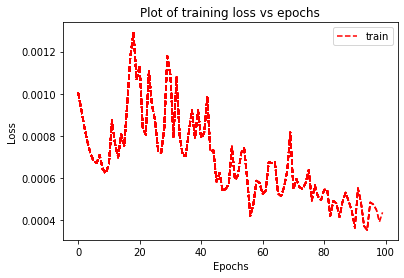

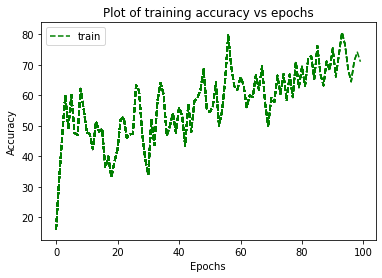

In [98]:
featLength = 2+5+2
# Initilaizing the model
model = perceptron(featLength).to(device)
criterion = nn.MSELoss() 
model = train_model(model,criterion,num_epochs=100,learning_rate=100) # Training the model

In [99]:
test_running_corr = 0
# Loading data in batches
batches = 0
testLabels = []

model.eval() # Testing the model in evaluation mode

for tsData in tqdm.notebook.tqdm(testLoader):
    inputs,labels = tsData
    
    inputs, labels = inputs.float().to(device),labels.float()      
    
    with torch.no_grad(): # No back-propagation during testing; gradient computation is not required
        
        # Feedforward train data batch through model
        output = model(inputs) 
        # Predicted class is the one with maximum probability
        _,preds = output.data.max(1)    
        if batches==0:
            totalPreds = preds
            testLabels = torch.argmax(labels,dim=1) # Converting 1-hot vector labels to integer labels
            batches = 1
        else:
            totalPreds = torch.cat((totalPreds,preds),0)
            testLabels = torch.cat((testLabels,torch.argmax(labels,dim=1)),0) 

# Finding total number of correct predictions
ts_corr = np.sum(np.equal(totalPreds.cpu().numpy(),testLabels.numpy()))
# Calculating accuracy
ts_acc = ts_corr/testLabels.shape[0]
print('Accuracy on test set = '+str(ts_acc*100)+'%')


Accuracy on test set = 68.88888888888889%
